# Классификация изображений с помощью scikit-learn

## Импорт библиотек

In [1]:
import os
import numpy as np
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt

import joblib

import skimage
from skimage.io import imread, imshow
from skimage.transform import resize, rescale

from sklearn.model_selection import train_test_split

from sklearn.base import BaseEstimator, TransformerMixin
from skimage.feature import hog

from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_predict, GridSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

## Импорт данных

In [2]:
data_path = os.path.abspath("images")
os.listdir(data_path)

['BearHead',
 'CatHead',
 'ChickenHead',
 'CowHead',
 'DeerHead',
 'DuckHead',
 'EagleHead',
 'ElephantHead',
 'HumanHead',
 'LionHead',
 'MonkeyHead',
 'MouseHead',
 'Natural',
 'PandaHead',
 'PigeonHead',
 'PigHead',
 'RabbitHead',
 'SheepHead',
 'TigerHead',
 'WolfHead']

In [3]:
def resize_all(src: str, include, width=150, height=None):
    """
    Загрузка изображений по пути, 
    изменение их размера 
    и сохранения их в виде массива тгьзн значений RGB словаре, 
    содержащем метки, имена файлов и описание.
    """
     
    height = height if height is not None else width
     
    data = dict()
    data['description'] = 'resized ({0}x{1})animal images in rgb'.format(int(width), int(height))
    data['label'] = []
    data['filename'] = []
    data['data'] = []   

    for subdir in os.listdir(src):
        if subdir in include:
            print(subdir)
            current_path = os.path.join(src, subdir)
 
            for file in os.listdir(current_path):
                if file[-3:] in {'jpg', 'png'}:
                    im = imread(os.path.join(current_path, file))
                    im = resize(im, (width, height)) 
                    data['label'].append(subdir)
                    data['filename'].append(file)
                    data['data'].append(im)
    return data

In [4]:
base_name = 'animal_heads'
width, height = 128, 128
include = set(os.listdir(data_path))
include

{'BearHead',
 'CatHead',
 'ChickenHead',
 'CowHead',
 'DeerHead',
 'DuckHead',
 'EagleHead',
 'ElephantHead',
 'HumanHead',
 'LionHead',
 'MonkeyHead',
 'MouseHead',
 'Natural',
 'PandaHead',
 'PigHead',
 'PigeonHead',
 'RabbitHead',
 'SheepHead',
 'TigerHead',
 'WolfHead'}

In [5]:
data = resize_all(src=data_path, include=include, width=width, height=height)

BearHead


CatHead
ChickenHead
CowHead
DeerHead
DuckHead
EagleHead
ElephantHead
HumanHead
LionHead
MonkeyHead
MouseHead
Natural
PandaHead
PigeonHead
PigHead
RabbitHead
SheepHead
TigerHead
WolfHead


## Экспорт пака данных

In [6]:
joblib.dump(data, f"{base_name}_{width}x{height}px.pkl")

['animal_heads_128x128px.pkl']

## Импорт пака данных

In [7]:
data = joblib.load(f'{base_name}_{width}x{height}px.pkl')

## Обработка данных

In [8]:
print('number of samples: ', len(data['data']))
print('keys: ', list(data.keys()))
print('description: ', data['description'])
print('image shape: ', data['data'][0].shape)
print('labels:', np.unique(data['label']))
 
Counter(data['label'])

number of samples:  1994
keys:  ['description', 'label', 'filename', 'data']
description:  resized (128x128)animal images in rgb
image shape:  (128, 128, 3)
labels: ['BearHead' 'CatHead' 'ChickenHead' 'CowHead' 'DeerHead' 'DuckHead'
 'EagleHead' 'ElephantHead' 'HumanHead' 'LionHead' 'MonkeyHead'
 'MouseHead' 'Natural' 'PandaHead' 'PigHead' 'PigeonHead' 'RabbitHead'
 'SheepHead' 'TigerHead' 'WolfHead']


Counter({'CatHead': 159,
         'PandaHead': 117,
         'TigerHead': 112,
         'DuckHead': 102,
         'BearHead': 101,
         'CowHead': 101,
         'DeerHead': 101,
         'PigHead': 101,
         'ChickenHead': 100,
         'ElephantHead': 100,
         'HumanHead': 100,
         'MonkeyHead': 100,
         'MouseHead': 100,
         'RabbitHead': 100,
         'SheepHead': 100,
         'WolfHead': 100,
         'PigeonHead': 98,
         'EagleHead': 97,
         'LionHead': 97,
         'Natural': 8})

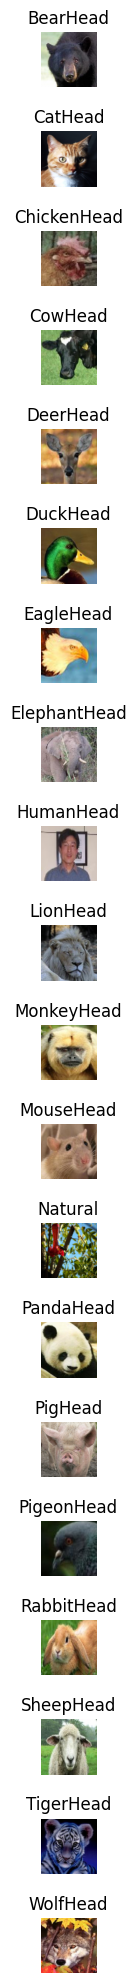

In [9]:
# use np.unique to get all unique values in the list of labels
labels = np.unique(data['label'])
 
# set up the matplotlib figure and axes, based on the number of labels
fig, axes = plt.subplots(len(labels), 1)
fig.set_size_inches(20, 20)
fig.tight_layout()
 
# make a plot for every label (equipment) type. The index method returns the 
# index of the first item corresponding to its search string, label in this case
for ax, label in zip(axes, labels):
    idx = data['label'].index(label)
     
    ax.imshow(data['data'][idx])
    ax.axis('off')
    ax.set_title(label)

In [10]:
x = np.array(data['data'])
y = np.array(data['label'])

Далее нам нужно разделить наши данные на тестовый и обучающий наборы. Мы используем функцию train_test_split из scikit-learn и используем 80% от общего набора для обучения, а остальное - для тестового набора. В наборе данных фотографии упорядочены по животным, поэтому мы не можем просто разделить их на 80%.

Чтобы понять почему, давайте посмотрим на таблицу ниже. Если данные упорядочены и мы разделяем их в некоторой позиции, то в итоге некоторые животные (типы) появятся только в одном из двух наборов. Например, коровы отображаются только в тестовом наборе. Это проблема, поскольку таким образом мы никогда не научим нашу модель распознавать коров, и, следовательно, она не сможет их правильно предсказать.

Мы можем решить эту проблему, перетасовав данные перед разделением. Таким образом, мы выравниваем распределения в обучающем и тестовом наборах и делаем их сопоставимыми.

Функция train_test_split в sklearn предоставляет параметр shuffle, который позаботится об этом при выполнении разделения. random_state запускает перетасовку, чтобы она была случайной, но воспроизводимой.

In [11]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, shuffle=True, random_state=42)

Чтобы убедиться в том, что распределение фотографий в обучающем и тестовом наборах аналогично, давайте посмотрим на относительное количество фотографий в каждой категории.

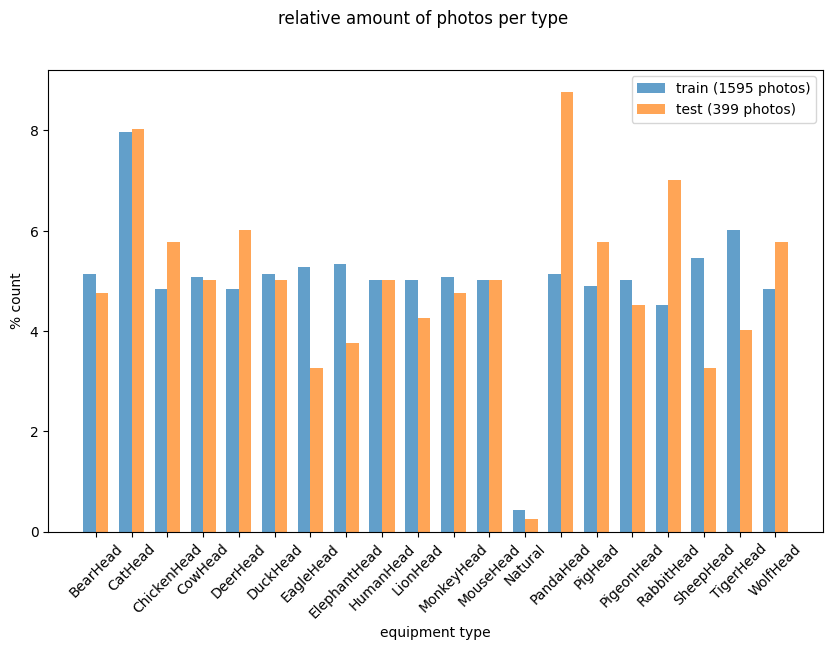

In [12]:
def plot_bar(y, loc='left', relative=True):
    width = 0.35
    if loc == 'left':
        n = -0.5
    elif loc == 'right':
        n = 0.5
     
    # calculate counts per type and sort, to ensure their order
    unique, counts = np.unique(y, return_counts=True)
    sorted_index = np.argsort(unique)
    unique = unique[sorted_index]
     
    if relative:
        # plot as a percentage
        counts = 100*counts[sorted_index]/len(y)
        ylabel_text = '% count'
    else:
        # plot counts
        counts = counts[sorted_index]
        ylabel_text = 'count'
         
    xtemp = np.arange(len(unique))
     
    plt.bar(xtemp + n*width, counts, align='center', alpha=.7, width=width)
    plt.xticks(xtemp, unique, rotation=45)
    plt.xlabel('equipment type')
    plt.ylabel(ylabel_text)
plt.figure(figsize=(10,6))
plt.suptitle('relative amount of photos per type')
plot_bar(y_train, loc='left')
plot_bar(y_test, loc='right')
plt.legend([
    'train ({0} photos)'.format(len(y_train)), 
    'test ({0} photos)'.format(len(y_test))
]);

Распределения не совсем равны, но на данный момент достаточно хороши. Обратите внимание, что наш набор данных довольно мал (~ 100 фотографий на категорию), поэтому разница в 1-2 фотографии в тестовом наборе окажет большое влияние на распределение. Для дальнейшего улучшения мы могли бы также использовать параметр stratify train_test_split для обеспечения равного распределения в обучающем и тестовом наборах.

## Обработка

Классическим подходом к распознаванию объектов является HOG-SVM, что расшифровывается как Гистограмма ориентированных градиентов и машины опорных векторов. HOGS используются для уменьшения количества объектов, другими словами: для снижения сложности задачи при сохранении как можно большего разнообразия.

Для вычисления HOG изображение делится на блоки, например 8 на 8 пикселей. Для каждого из этих блоков вычисляется величина градиента в заданном количестве направлений. Для получения подробного объяснения мы обращаемся к http://www.learnopencv.com/histogram-of-oriented-gradients/.

Здесь мы просто рассмотрим пример:

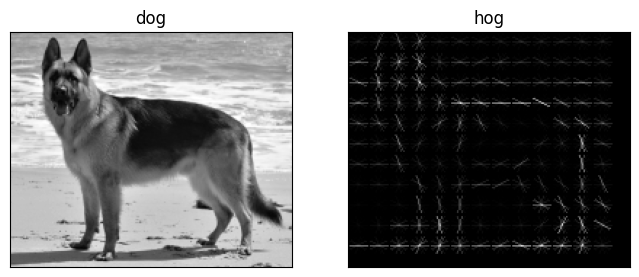

In [13]:
dog = imread('Kim_at_14_weeks.jpg', as_gray=True)
# https://en.wikipedia.org/wiki/German_Shepherd#/media/File:Kim_at_14_weeks.jpg
 
# scale down the image to one third
dog = rescale(dog, 1/3, mode='reflect')
# calculate the hog and return a visual representation.
dog_hog, dog_hog_img = hog(
    dog, pixels_per_cell=(14,14), 
    cells_per_block=(2, 2), 
    orientations=9, 
    visualize=True, 
    block_norm='L2-Hys')
 
fig, ax = plt.subplots(1,2)
fig.set_size_inches(8,6)
# remove ticks and their labels
[a.tick_params(bottom=False, left=False, labelbottom=False, labelleft=False) 
    for a in ax]
 
ax[0].imshow(dog, cmap='gray')
ax[0].set_title('dog')
ax[1].imshow(dog_hog_img, cmap='gray')
ax[1].set_title('hog')
plt.show()

In [14]:
print('number of pixels: ', dog.shape[0] * dog.shape[1])
print('number of hog features: ', dog_hog.shape[0])

number of pixels:  31428
number of hog features:  4320


Количество обрабатываемых точек данных в нашей модели сократилось до ~ 15%, и при некотором воображении мы все еще можем распознать собаку в БОРОВЕ.

## Трансформеры

При расчете нашего HOG мы выполнили преобразование. Мы можем преобразовать весь наш набор данных с помощью трансформаторов. Это объекты, которые берут массив данных, преобразуют каждый элемент и возвращают результирующие данные.

Здесь нам нужно преобразовать цветные изображения в оттенки серого, вычислить их значения и, наконец, масштабировать данные. Для этого мы используем три преобразователя подряд: RGB2GrayTransformer, HOGTransformer и StandardScaler. Конечным результатом является массив с HOG для каждого изображения во входных данных.

Scikit-learn поставляется со многими встроенными преобразователями, такими как стандартный масштабатор для масштабирования объектов и бинаризатор для сопоставления строковых объектов с числовыми объектами. Кроме того, оно предоставляет классы BaseEstimator и TransformerMixin для облегчения создания ваших собственных трансформеров.

Пользовательский преобразователь может быть создан путем наследования от этих двух классов и реализации метода __init__, подгонки и преобразования. Класс TransformerMixin предоставляет метод fit_transform, который сочетает в себе подгонку и преобразование, которые мы реализовали.

Ниже мы определяем RGB2GrayTransformer и HOGTransformer.

In [15]:
class RGB2GrayTransformer(BaseEstimator, TransformerMixin):
    """Convert an array of RGB images to grayscale"""
 
    def __init__(self):
        pass
 
    def fit(self, X, y=None):
        """returns itself"""
        return self
 
    def transform(self, x, y=None):
        """perform the transformation and return an array"""
        return np.array([skimage.color.rgb2gray(img) for img in x])
     
 
class HogTransformer(BaseEstimator, TransformerMixin):
    """
    Expects an array of 2d arrays (1 channel images)
    Calculates hog features for each img
    """
 
    def __init__(self, y=None, orientations=9,
                 pixels_per_cell=(8, 8),
                 cells_per_block=(3, 3), block_norm='L2-Hys'):
        self.y = y
        self.orientations = orientations
        self.pixels_per_cell = pixels_per_cell
        self.cells_per_block = cells_per_block
        self.block_norm = block_norm
 
    def fit(self, x, y=None):
        return self
 
    def transform(self, x, y=None):
 
        def local_hog(x):
            return hog(x,
                       orientations=self.orientations,
                       pixels_per_cell=self.pixels_per_cell,
                       cells_per_block=self.cells_per_block,
                       block_norm=self.block_norm)
 
        try: # parallel
            return np.array([local_hog(img) for img in x])
        except:
            return np.array([local_hog(img) for img in x])

Обратите внимание, что для совместимости с scikit-learn методы подгонки и преобразования принимают как X, так и y в качестве параметров, хотя y здесь не используется.

С помощью этого мы все готовы к предварительной обработке наших RGB-изображений для масштабирования объектов HOG.

In [16]:
# create an instance of each transformer
grayify = RGB2GrayTransformer()
hogify = HogTransformer(
    pixels_per_cell=(14, 14), 
    cells_per_block=(2,2), 
    orientations=9, 
    block_norm='L2-Hys'
)
scalify = StandardScaler()

In [17]:
# call fit_transform on each transform converting X_train step by step
x_train_gray = grayify.fit_transform(x_train)
x_train_hog = hogify.fit_transform(x_train_gray)
x_train_prepared = scalify.fit_transform(x_train_hog)
 
print(x_train_prepared.shape)

(1595, 2304)


In [18]:
labels = np.unique(data['label'])
print(len(labels))

x_gray = grayify.fit_transform(x)
print(x_gray.shape)

# from skimage.transform import rescale
# x_gray_rescaled = rescale(x_gray, 1/3, mode='reflect')

x_hog_lst = []
for i, el in enumerate(x_gray):
    x_hog, x_hog_img = hog(
        x_gray[i], pixels_per_cell=(14, 14), 
        cells_per_block=(2, 2), 
        orientations=9, 
        visualize=True, 
        block_norm='L2-Hys')
    x_hog_lst.append(x_hog_img)

20
(1994, 128, 128)


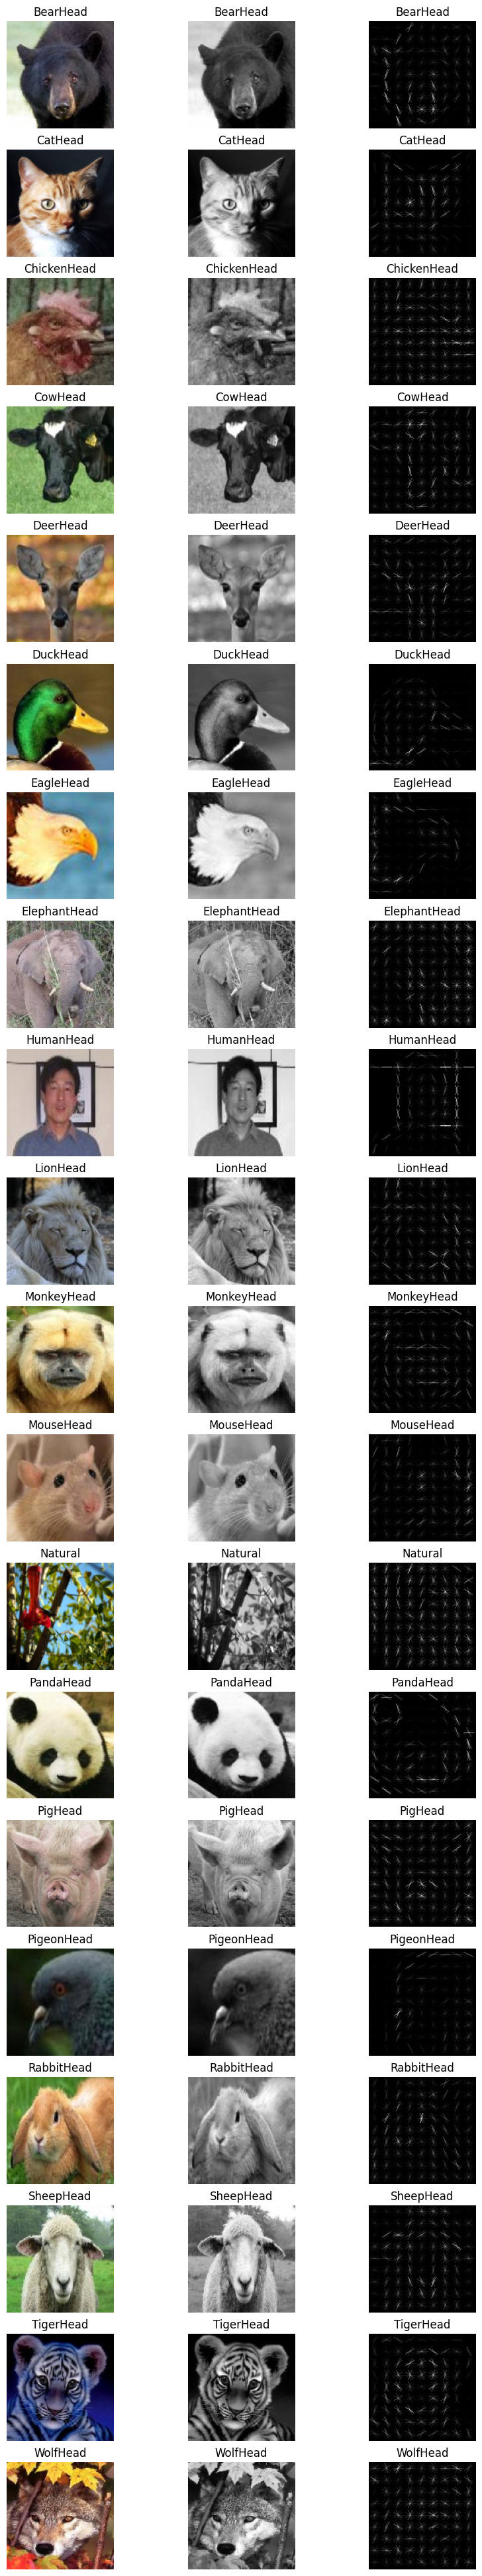

In [19]:
fig, axes = plt.subplots(20, 3)

fig.set_size_inches(15, 4)
fig.set_figheight(50)
fig.set_figwidth(10)

k = 1  # будет отвечать за то, какое изображение нужно отобразить

for ax, label in zip(axes, labels):
    for ax1 in ax:
        
        idx = data['label'].index(label)

        if k == 1: ax1.imshow(x[idx], cmap='gray')
        if k == 2: ax1.imshow(x_gray[idx], cmap='gray')
        if k == 3: ax1.imshow(x_hog_lst[idx], cmap='gray')
        
        k += 1
        if k > 3: k = 1

        ax1.axis('off')
        ax1.set_title(label)

## Обучение

Следующим шагом будет обучение классификатора. Мы начнем со стохастического градиентного спуска (SGD), потому что он быстрый и работает достаточно хорошо.

In [20]:
sgd_clf = SGDClassifier(random_state=42, max_iter=1000, tol=1e-3)
sgd_clf.fit(x_train_prepared, y_train)

SGDClassifier(random_state=42)

## Тестирование

Для тестирования обученного классификатора SGD мы будем использовать наш тестовый набор. Сначала мы преобразуем его, используя те же преобразователи, что и раньше. Однако мы должны позаботиться о том, чтобы наши тестовые данные не повлияли на преобразователи. Некоторые преобразователи, такие как PCA (анализ основных компонентов), могут оптимизировать данные перед применением преобразования. Чтобы предотвратить это, мы вызываем transform, а не fit_transform для тестовых данных.

In [21]:
x_test_gray = grayify.transform(x_test)
x_test_hog = hogify.transform(x_test_gray)
x_test_prepared = scalify.transform(x_test_hog)

In [22]:
y_pred = sgd_clf.predict(x_test_prepared)
print(np.array(y_pred == y_test)[:25])
print('')
print('Percentage correct: ', 100*np.sum(y_pred == y_test)/len(y_test))

[ True False  True False  True  True  True  True  True  True  True  True
  True  True False False  True  True  True  True False  True  True  True
  True]

Percentage correct:  76.69172932330827


## Матрица путаницы

Процент, подобный приведенному выше, хорош, но это еще не вся история. Например, как насчет ложноположительных результатов? Чтобы лучше понять результаты, мы можем использовать корреляционную матрицу. Это таблица, в которой каждая строка соответствует метке, а каждый столбец - прогнозу.

Мы проиллюстрируем это с помощью фрейма данных pandas с некоторыми данными "да" / "нет".

In [23]:
y_pred = sgd_clf.predict(x_test_prepared)
print(np.array(y_pred == y_test))
print('percentage correct: ', str(100*np.sum(y_pred==y_test)/len(y_test)))

[ True False  True False  True  True  True  True  True  True  True  True
  True  True False False  True  True  True  True False  True  True  True
  True False  True  True  True  True  True False False  True  True False
  True  True False  True  True  True False  True  True False  True  True
 False  True  True  True False False  True  True  True  True  True  True
  True False  True  True  True  True  True  True  True  True False  True
  True  True False  True  True  True  True  True  True  True False  True
 False  True False False False  True  True False  True  True  True False
  True  True  True False  True  True  True False  True  True False False
  True  True  True  True  True  True False  True  True  True False False
  True False  True False  True False False  True False  True  True  True
  True  True  True  True  True  True  True  True  True  True  True False
 False  True  True  True  True  True  True  True  True False  True  True
 False  True  True False False  True False False  T

In [24]:
df_x = pd.DataFrame(x_test_prepared)
df_x

,0,1,2,3,4,5,6,7,8,9,...,2294,2295,2296,2297,2298,2299,2300,2301,2302,2303
0,-0.984265,0.325074,0.769554,-0.242857,2.254025,-0.589016,0.292637,-0.657009,-1.095598,-1.275112,...,0.838850,-1.267832,-0.916830,-1.173874,-1.241706,-1.196084,-0.996820,-0.359769,1.693214,0.916137
1,-0.741769,-0.735573,-0.765464,-0.268337,-0.370091,-0.006341,-0.456077,-0.699113,-0.707204,-1.071166,...,-0.900315,-1.023655,0.170014,-0.263474,0.880661,-0.016565,0.485330,0.958434,0.839298,-0.091968
2,-1.324637,-0.958241,-1.053895,-0.721221,-0.539117,-0.932442,-0.970844,-0.998732,-1.063146,-1.400145,...,-1.239317,-0.915058,-0.831265,-0.837999,-0.910053,-0.921290,-0.897065,-0.961168,-1.198805,-0.971653
3,-1.135601,-0.956569,-0.983878,-0.555719,1.299267,-0.785867,-0.708138,-0.561281,-0.978430,-0.746124,...,-0.917142,0.021516,0.643920,1.443318,0.160493,0.854906,0.318690,-0.004354,-0.984807,-0.748547
4,-1.175929,-0.799621,-0.209414,-0.159538,-1.056247,-1.037165,-0.969302,-1.036663,-1.017107,-1.364572,...,1.108951,-0.483741,0.331006,0.478427,0.240930,-0.163555,-0.714992,-0.049395,-0.540890,-0.422325
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
394,0.873665,1.619528,0.029431,0.013674,0.668558,0.185905,0.402163,1.547549,1.487747,0.784537,...,-0.371861,-0.649875,-0.938404,-0.183691,-1.045630,-0.768501,-0.457951,2.684613,2.498013,0.868497
395,-0.231954,0.393078,0.368405,0.246006,-0.680884,-0.712388,-0.403778,1.203473,0.021951,0.420320,...,0.168881,0.856225,0.805848,1.864596,-0.120752,-0.427555,-1.026465,-1.075520,-0.510670,-0.292938
396,0.295111,-0.236889,0.226342,-0.189522,0.551803,0.469963,0.822667,0.989848,1.321435,0.662814,...,0.306995,1.001718,1.522827,0.599694,0.401933,0.131190,-0.774099,0.342288,-0.215162,0.936092
397,0.280252,0.597463,1.482932,0.312035,-0.080199,-0.033953,-0.003407,-0.025655,0.228981,0.965539,...,0.799581,0.046716,-0.087753,-0.025886,-0.250782,0.014107,1.044824,0.568257,1.018313,0.801929


In [25]:
df_y = pd.DataFrame(y_test)
df_y

,0
0,HumanHead
1,RabbitHead
2,CowHead
3,RabbitHead
4,ElephantHead
...,...
394,HumanHead
395,ChickenHead
396,DuckHead
397,LionHead


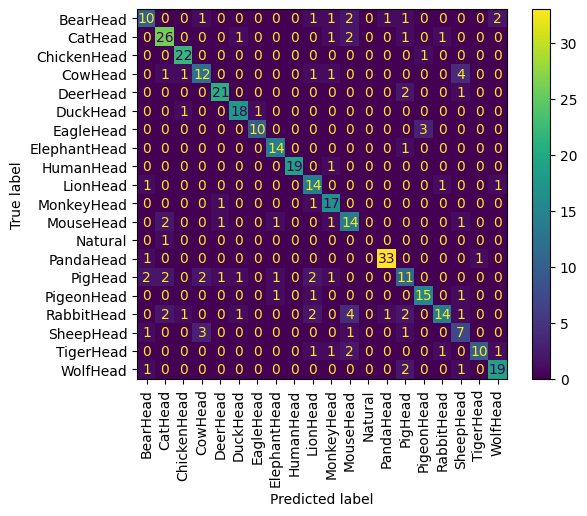

In [26]:
ConfusionMatrixDisplay.from_estimator(sgd_clf, df_x, df_y, xticks_rotation=90);

In [27]:
labels = ['yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'no',  'no', 'no', 'no']
predictions = ['yes', 'yes', 'yes', 'yes', 'no',  'no',  'yes', 'no', 'no', 'no']
 
# put the data in a dataframe for pretty printing
df = pd.DataFrame(
    np.c_[labels, predictions], 
    columns=['true_label', 'prediction']
)
df

,true_label,prediction
0,yes,yes
1,yes,yes
2,yes,yes
3,yes,yes
4,yes,no
5,yes,no
6,no,yes
7,no,no
8,no,no
9,no,no


Для создания матрицы путаницы мы используем функцию confusion_matrix из sklearn.metrics. Помимо двух списков, которые мы создали выше, мы также передаем массив labels со значениями меток. Это делается только для того, чтобы контролировать порядок, в котором они отображаются в матрице. Если мы оставим это, они будут отсортированы в алфавитном порядке. Столбцы дают нам прогнозы, а вдоль индекса мы находим реальные метки.

In [28]:
label_names = ['yes', 'no']
cmx = confusion_matrix(labels, predictions, labels=label_names)
df = pd.DataFrame(cmx, columns=label_names, index=label_names)
df.columns.name = 'prediction'
df.index.name = 'label'
df

prediction,yes,no
label,,
yes,4,2
no,1,3


Главная диагональ соответствует правильным прогнозам. В этом бинарном случае ложноположительные результаты отображаются ниже, а ложноотрицательные - выше диагонали.

Другой способ представить это в виде цветовой карты изображения.

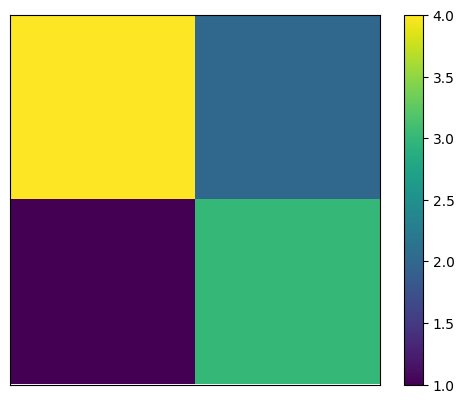

In [29]:
plt.imshow(cmx)
plt.xticks([])
plt.yticks([])
plt.colorbar();

Матрица путаницы для теста SGD представляет собой матрицу 8 × 8. Как указано выше, правильные прогнозы отображаются на главной диагонали, тогда как все недиагональные значения соответствуют неправильным классификациям.

In [30]:
cmx = confusion_matrix(y_test, y_pred)
cmx

array([[10,  0,  0,  1,  0,  0,  0,  0,  0,  1,  1,  2,  0,  1,  1,  0,
         0,  0,  0,  2],
       [ 0, 26,  0,  0,  0,  1,  0,  0,  0,  0,  1,  2,  0,  0,  1,  0,
         1,  0,  0,  0],
       [ 0,  0, 22,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,
         0,  0,  0,  0],
       [ 0,  1,  1, 12,  0,  0,  0,  0,  0,  1,  1,  0,  0,  0,  0,  0,
         0,  4,  0,  0],
       [ 0,  0,  0,  0, 21,  0,  0,  0,  0,  0,  0,  0,  0,  0,  2,  0,
         0,  1,  0,  0],
       [ 0,  0,  1,  0,  0, 18,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0, 10,  0,  0,  0,  0,  0,  0,  0,  0,  3,
         0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0, 14,  0,  0,  0,  0,  0,  0,  1,  0,
         0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0, 19,  0,  1,  0,  0,  0,  0,  0,
         0,  0,  0,  0],
       [ 1,  0,  0,  0,  0,  0,  0,  0,  0, 14,  0,  0,  0,  0,  0,  0,
         1,  0,  0,  1],
       [ 0,  0,  0,  0,  1,  0

Наибольшие значения приходятся на диагональ, следовательно, большинство прогнозов верны, но есть ошибки (~ 15%). Чтобы более четко визуализировать это в виде изображения, мы делаем две вещи. Сначала мы нормализуем матрицу до 100, деля каждое значение на сумму его строки (т. Е. количество фактических элементов с определенной меткой). Во-вторых, мы установили для главной диагонали значение 0, чтобы сосредоточиться на неправильных прогнозах.


 ['BearHead', 'CatHead', 'ChickenHead', 'CowHead', 'DeerHead', 'DuckHead', 'EagleHead', 'ElephantHead', 'HumanHead', 'LionHead', 'MonkeyHead', 'MouseHead', 'Natural', 'PandaHead', 'PigHead', 'PigeonHead', 'RabbitHead', 'SheepHead', 'TigerHead', 'WolfHead']


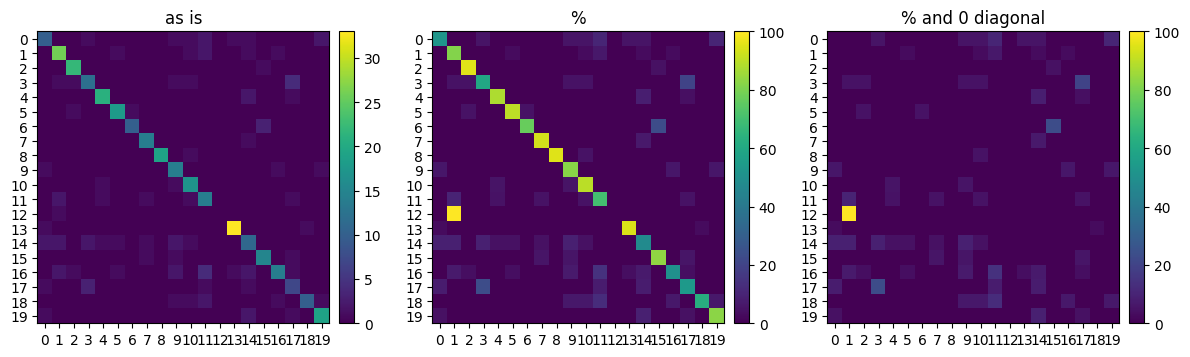

In [31]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
 
def plot_confusion_matrix(cmx, vmax1=None, vmax2=None, vmax3=None):
    cmx_norm = 100*cmx / cmx.sum(axis=1, keepdims=True)
    cmx_zero_diag = cmx_norm.copy()
 
    np.fill_diagonal(cmx_zero_diag, 0)
 
    fig, ax = plt.subplots(ncols=3)
    fig.set_size_inches(12, 6)
    [a.set_xticks(range(len(cmx)+1)) for a in ax]
    [a.set_yticks(range(len(cmx)+1)) for a in ax]
         
    im1 = ax[0].imshow(cmx, vmax=vmax1)
    ax[0].set_title('as is')
    im2 = ax[1].imshow(cmx_norm, vmax=vmax2)
    ax[1].set_title('%')
    im3 = ax[2].imshow(cmx_zero_diag, vmax=vmax3)
    ax[2].set_title('% and 0 diagonal')
 
    dividers = [make_axes_locatable(a) for a in ax]
    cax1, cax2, cax3 = [divider.append_axes("right", size="5%", pad=0.1) 
                        for divider in dividers]
 
    fig.colorbar(im1, cax=cax1)
    fig.colorbar(im2, cax=cax2)
    fig.colorbar(im3, cax=cax3)
    fig.tight_layout()
     
plot_confusion_matrix(cmx)
 
# the types appear in this order
print('\n', sorted(np.unique(y_test)))

Чтобы сделать правильные выводы, нам часто приходится комбинировать то, что мы видим в матрице путаницы, с тем, что мы уже знаем о данных. Например, у нас довольно высокий процент орлов, классифицируемых как куры. Не в обиду ни орлам, ни курам, но в этом наборе они похожи. Кроме того, не все фотографии получаются очень четкими, возможно, мы могли бы изучить другие методы выделения объектов или использовать изображения с немного более высоким разрешением.

## Оптимизация

Оценка 85% - это неплохо для первой попытки и с небольшим набором данных, но, скорее всего, ее можно улучшить. Поскольку у нас уже есть куча параметров для игры, было бы неплохо автоматизировать оптимизацию. В следующей части мы настроим конвейер, который предварительно обрабатывает данные, обучает модель и позволяет нам легче работать с параметрами.

Метод pipeline fit принимает входные данные и преобразует их поэтапно, последовательно вызывая метод fit_transform для каждого преобразователя. Данные передаются с вывода на вход до тех пор, пока не достигнут конца или оценщика, если таковой имеется. Когда последним элементом в конвейере является оценщик, вызывается его метод подгонки для обучения модели с использованием преобразованных данных.

Полученный объект можно использовать непосредственно для составления прогнозов. Тестовые данные передаются в метод predict, который вызывает методы transform, за которыми на заключительном шаге следует predict.

Запуск с нашей системой показывает, что результат конвейера идентичен результату, который мы имели раньше.

In [32]:
from sklearn.pipeline import Pipeline
from sklearn import svm
 
HOG_pipeline = Pipeline([
    ('grayify', RGB2GrayTransformer()),
    ('hogify', HogTransformer(
        pixels_per_cell=(14, 14), 
        cells_per_block=(2, 2), 
        orientations=9, 
        block_norm='L2-Hys')
    ),
    ('scalify', StandardScaler()),
    ('classify', SGDClassifier(random_state=42, max_iter=1000, tol=1e-3))
])
 
clf = HOG_pipeline.fit(x_train, y_train)
print('Percentage correct: ', 100*np.sum(clf.predict(x_test) == y_test)/len(y_test))


Percentage correct:  76.69172932330827


## Поиск по сетке

Огромным преимуществом здесь является то, что, используя наш конвейер, мы можем оптимизировать как преобразования, так и классификатор в одной процедуре. Кроме того, вместо ручного изменения параметров мы будем использовать GridSearchCV. Сначала мы определяем сетку параметров, как показано в ячейке ниже.

Преобразователи и оценщики обозначаются их именем, например "классифицировать". Их параметры обозначаются ‘name__parameter’. Наша таблица параметров состоит из двух словарей. В первом мы пытаемся улучшить HOGTransformer. Во втором мы тестируем SGD по сравнению с SVM. GridSearchCV проверит все комбинации в каждом словаре, так что всего у нас будет, 2 * 2 * 3 + 2 = 14, . Поскольку оптимальная предварительная обработка может варьироваться в зависимости от модели, часто бывает хорошей идеей выполнить их совместный поиск по сетке, чтобы найти глобальный оптимум. Итак, лучшей сеткой была бы такая, в которой параметры hogify и classify варьировались бы вместе (путем размещения их в одном словаре).

In [33]:
param_grid = [
    {
        'hogify__orientations': [8, 9],
        'hogify__cells_per_block': [(2, 2), (3, 3)],
        'hogify__pixels_per_cell': [(8, 8), (10, 10), (12, 12)]
    },
    {
        'hogify__orientations': [8],
         'hogify__cells_per_block': [(3, 3)],
         'hogify__pixels_per_cell': [(8, 8)],
         'classify': [
             SGDClassifier(random_state=42, max_iter=1000, tol=1e-3),
             svm.SVC(kernel='linear')
         ]
    }
]

Далее мы создаем объект GridSearchCV, передаем конвейер и параметр grid . Кроме того, мы используем cv=3. Этот параметр настраивает перекрестную проверку. Это означает, что набор данных разбивается на сгибы (в данном случае на 3) и выполняется несколько обучающих запусков. В каждом запуске один сгиб используется для проверки, а остальные - для обучения. Таким образом, модель может быть проверена и улучшена на основе части обучающих данных, не затрагивая тестовые данные. Для окончательного параметра, оценки, мы используем ‘точность’, процент истинных положительных прогнозов. В других случаях может оказаться более полезным использовать проверку ложноположительных результатов или другую статистику.

Параметр n_jobs определяет количество заданий, которые мы хотим выполнять параллельно. Мы устанавливаем его значение равным -1, чтобы использовать все доступные ядра. Обратите внимание, что это работает в ноутбуках в Linux и, возможно, OSX, но не в MS Windows.

Для распараллеливания под Windows необходимо запустить этот код из скрипта внутри предложения if __name__ == ‘__main__’. Дополнительные пояснения можно найти в документации joblib.

In [34]:
grid_search = GridSearchCV(HOG_pipeline, 
                           param_grid, 
                           cv=3,
                           n_jobs=-1,
                           scoring='accuracy',
                           verbose=1,
                           return_train_score=True)
 
grid_res = grid_search.fit(x_train, y_train)

Fitting 3 folds for each of 14 candidates, totalling 42 fits


Когда поиск по сетке будет завершен, модель будет обучена в последний раз, используя полный набор тренировок и оптимальные параметры. Мы можем поместить результирующий объект в файл pickle и загрузить его, когда захотим его использовать. Мы также можем использовать различные методы для просмотра результатов и оценок во время поиска. Обратите внимание на подчеркивание в конце в свойствах: это соглашение scikit-learn, используемое для свойств, которые появились только после выполнения подгонки.

In [ ]:
# save the model to disk
joblib.dump(grid_res, 'hog_sgd_model.pkl');

In [ ]:
# description of the best performing object, a pipeline in our case.
grid_res.best_estimator_

Pipeline(steps=[('grayify', RGB2GrayTransformer()),
                ('hogify', HogTransformer(orientations=8)),
                ('scalify', StandardScaler()),
                ('classify', SVC(kernel='linear'))])

Кроме того, запустите grid_res.cv_results_, чтобы получить подробный журнал поиска по сетке. Результат здесь не показан, так как он довольно длинный. Чтобы иметь возможность извлекать этот журнал в sklearn версии 0.21 и выше, аргументу return_train_score GridSearchCV должно быть присвоено значение True.

In [ ]:
# the highscore during the search
grid_res.best_score_

0.8037631744143786

In [ ]:
print(grid_res.best_params_)

{'classify': SVC(kernel='linear'), 'hogify__cells_per_block': (3, 3), 'hogify__orientations': 8, 'hogify__pixels_per_cell': (8, 8)}


Поскольку количество запусков имеет тенденцию к быстрому увеличению во время поиска по сетке, иногда полезно использовать RandomizedSearchCV. Это работает так же, как поиск по сетке, но выбирает указанное (n_iter) количество случайных наборов параметров из сетки. Это может быть хорошим способом получить приблизительную оценку оптимальных параметров, прежде чем использовать GridSearchCV для точной настройки.

Возвращаясь к нашим результатам GridSearchCV, наши лучшие результаты были получены с помощью линейного SVM. В качестве заключительного теста мы используем модель для прогнозирования нашего тестового набора, как мы делали выше.

In [ ]:
best_pred = grid_res.predict(x_test)
print('Percentage correct: ', 100*np.sum(best_pred == y_test)/len(y_test))

Percentage correct:  80.95238095238095


Точность повысилась с 85% до 92%. Чтобы получить более полное представление, мы можем сравнить матрицы путаницы до и после оптимизации. Обратите внимание, что для сравнения задается больший из двух цветовых диапазонов.

In [ ]:
cmx_svm = confusion_matrix(y_test, best_pred)

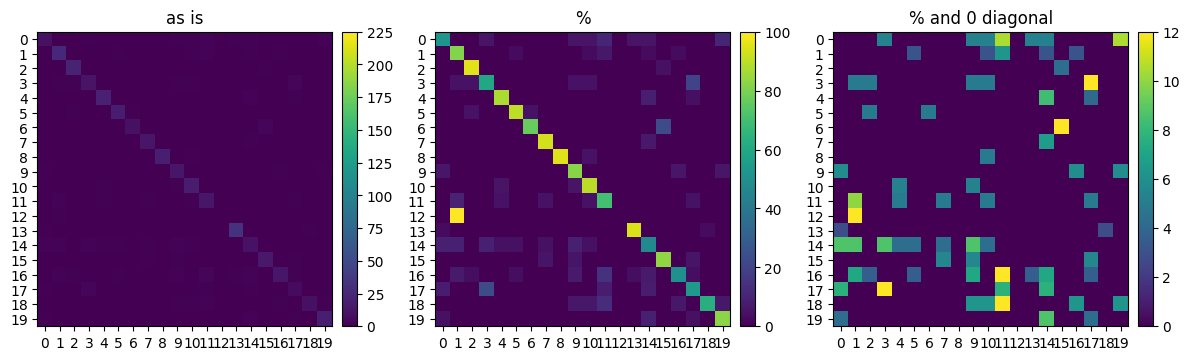

In [ ]:
plot_confusion_matrix(cmx, vmax1=225, vmax2=100, vmax3=12)

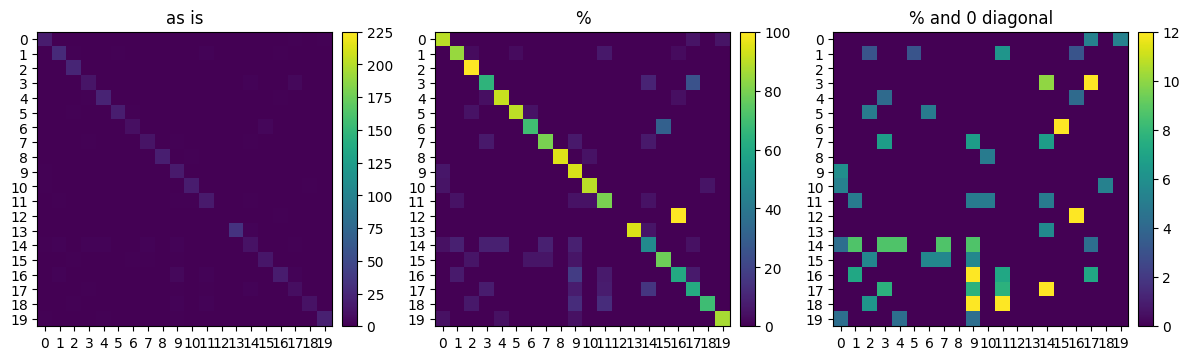

In [ ]:
plot_confusion_matrix(cmx_svm, vmax1=225, vmax2=100, vmax3=12)

В крайнем правом углу мы можем увидеть, где произошли улучшения (кажется, мы превратили цыплят в орлов). Теперь мы можем попытаться найти конкретные проблемы в данных или выполнить извлечение объектов для дальнейшего улучшения. К счастью, с помощью созданного нами инструментария мы можем позволить компьютеру выполнять значительную часть этой работы за нас.

## Заключение

В заключение мы построили базовую модель для классификации изображений на основе их основных характеристик. Кроме того, мы настроили наш инструментарий для систематического улучшения модели автоматизированным способом. И самое главное, эта методология является универсальной и может быть применена ко всем видам задач машинного обучения.